transfer learning between a 1Dgamma and a 1Dgamma function with fixed parameters.

In [9]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot
import quantum_classical_1Dgamma as qc
from matplotlib.offsetbox import AnchoredText
import pandas as pd
from scipy import stats
import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads

In [2]:
# functions

def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems


def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham


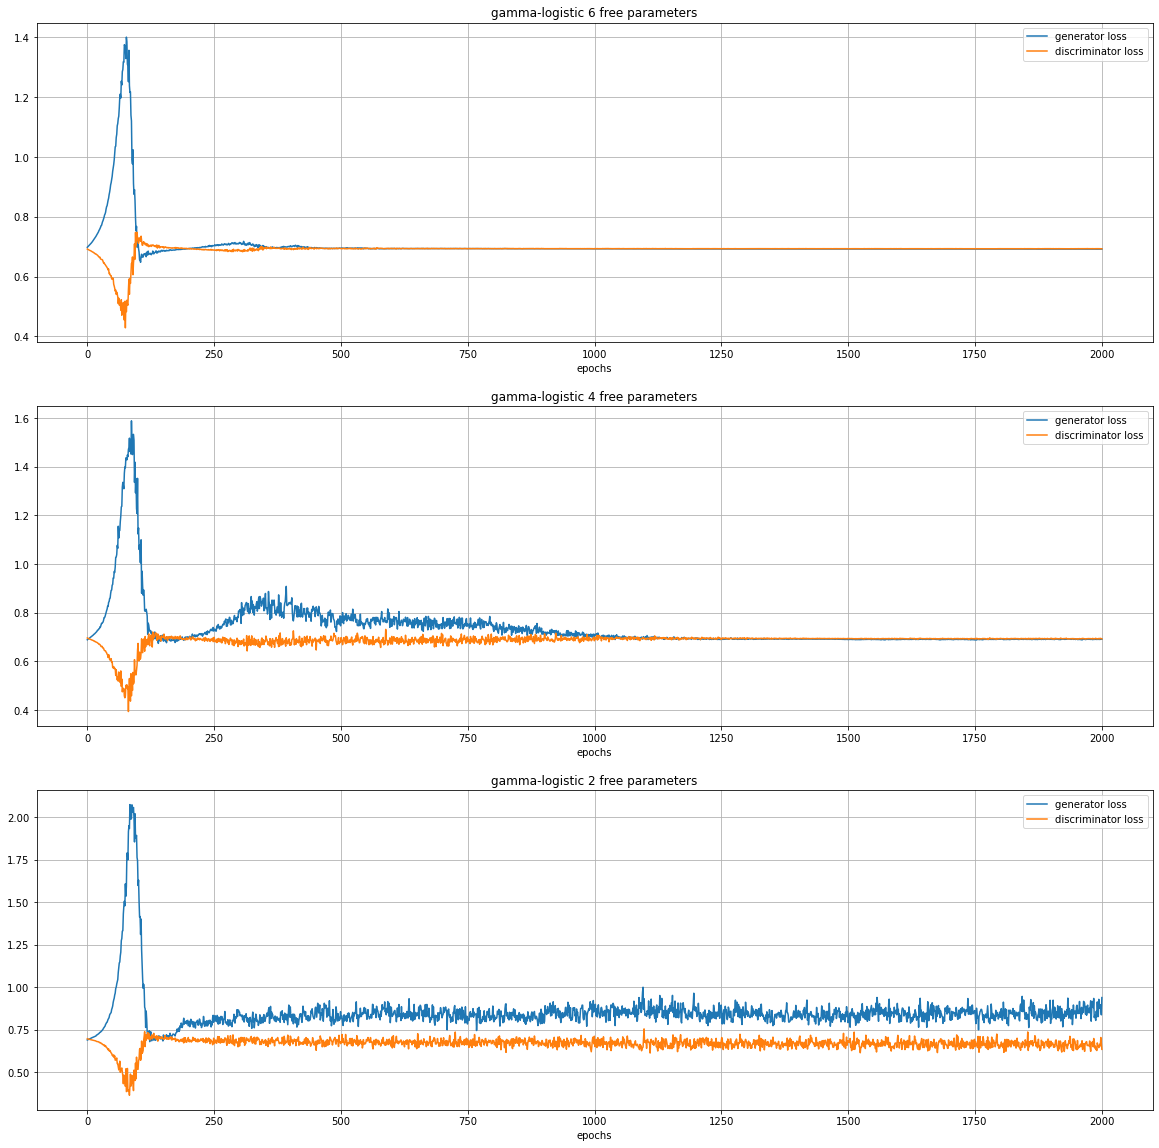

In [3]:
n_layers=128
fixed_params=[4, 6, 8]
pyplot.figure(figsize=(20,20))
rows=3
cols=1
for i, val in enumerate(fixed_params):
    pyplot.subplot(rows,cols,i+1)
    d_loss = np.loadtxt(f"dloss_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_{val}", delimiter=' ')
    g_loss= np.loadtxt(f"gloss_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_{val}", delimiter=' ')
    #d_loss=d_loss[:10000]
    #g_loss=g_loss[:10000]
    #pyplot.figure(figsize=(20, 7), dpi=80)
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss')
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss')
    pyplot.title(f'gamma-logistic {10-val} free parameters')
    pyplot.xlabel('epochs')
    pyplot.legend()
    pyplot.grid()

pyplot.show()


[-0.02746012 -0.71471591  0.01217367  0.01722071  0.04844138 -0.57531328]
[ 0.37134523  1.01404998  0.0514021  -1.38534807]
[ 0.0212198  -1.21692358]


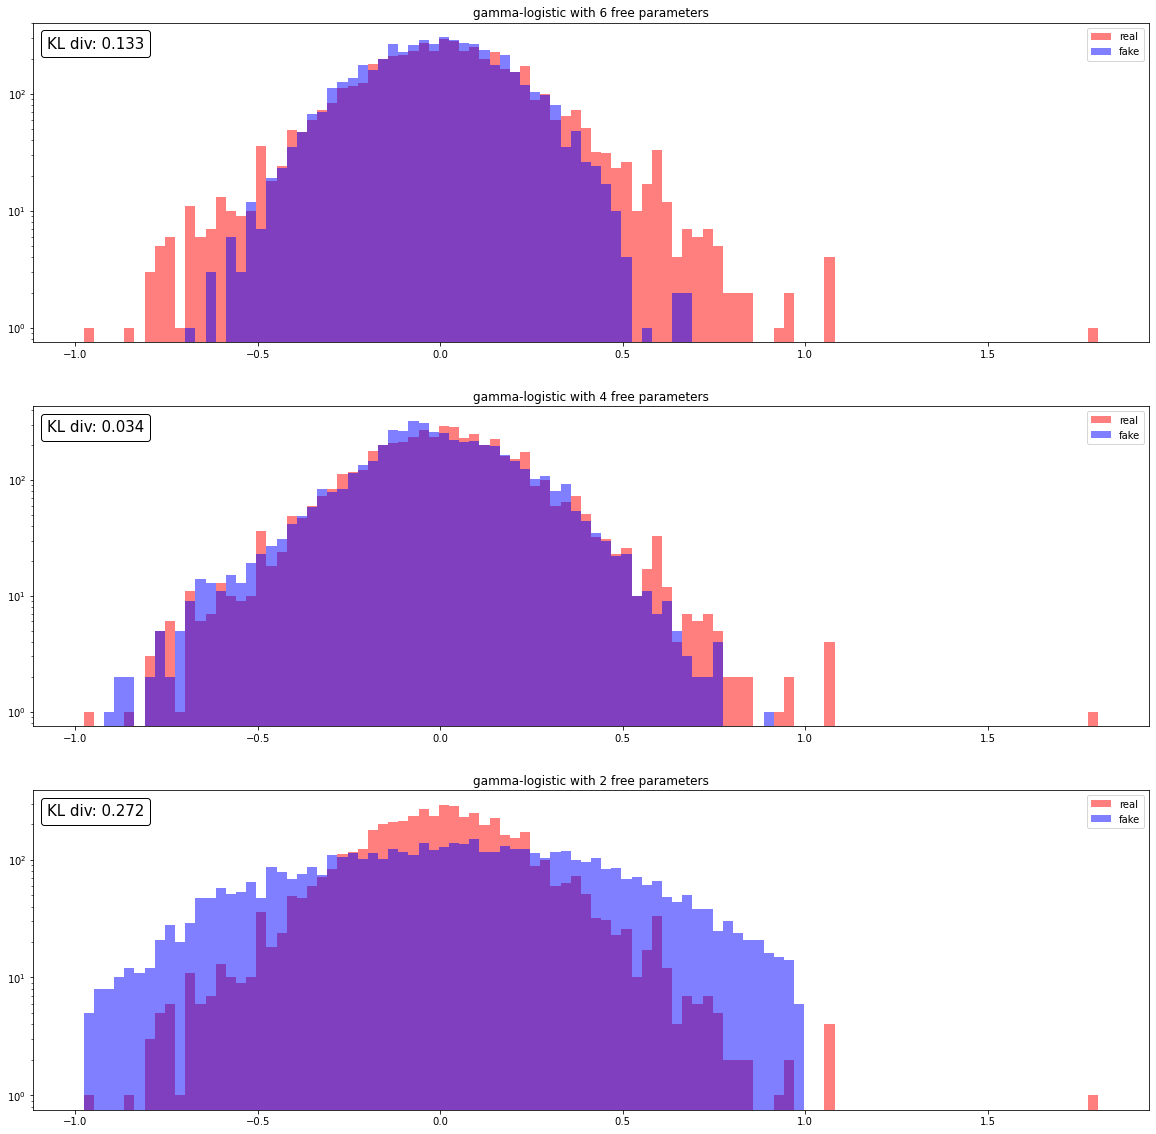

In [5]:
# number of qubits generator
nqubits = 1
# create hamiltonians
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham
hamiltonian1 = hamiltonian1()

latent_dim=3
samples=5000
nqubits=1
layers=2
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0)) 
    
pyplot.figure(figsize=(20, 20))

s=qc.generate_training_real_samples(samples)
x_real, y_real = qc.generate_real_samples(samples, s, 3000)

distributions=[]
distributions.append(x_real)
for i, val in enumerate(fixed_params):
    params = np.loadtxt(f"PARAMS_1Dgamma_1_3_2_10000_{n_layers}_0.1_fixed_params_{val}", delimiter=' ', unpack='true')
    print(params)
    params = tf.Variable(params)
    #print(params)
    x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1,val)
    distributions.append(x_fake)
    #x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)
    #s=qc.generate_training_real_samples(samples)
    #x_real, y_real = qc.generate_real_samples(samples, s, 3000)

    nbins=100
    pyplot.subplot(rows,cols,i+1)
    #pyplot.figure(figsize=(14, 7))
    bins_real=pyplot.hist(x_real, color='red', bins=nbins,label='real', alpha=0.5)
    bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)
    ax=pyplot.gca()
    at = AnchoredText(
    f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    #pyplot.text( 0.,0.,"prova", bbox=dict(facecolor='red', alpha=0.5))
    #pyplot.xlim(-1,1)
    pyplot.yscale('log')
    pyplot.title(f'gamma-logistic with {10-val} free parameters')
    pyplot.legend()
pyplot.show()

In [11]:
from IPython.display import display
moments = pd.DataFrame(
    {
        "distribution":["real","fake 4 free parameters", "fake 6 free parameters", "fake 8 free parameters" ],
        "mean":[np.mean(i) for i in distributions],
        "2 moment ":[stats.moment(i,moment=2)[0] for i in distributions],
        "3 moment":[stats.moment(i,moment=3)[0] for i in distributions],
        "4 moment ":[stats.moment(i,moment=4)[0] for i in distributions]
    }
)
display(moments)

,distribution,mean,2 moment,3 moment,4 moment
0,real,0.010618,0.056472,0.002768,0.014602
1,fake 4 free parameters,-0.010106,0.036277,-0.000264,0.003796
2,fake 6 free parameters,-0.006045,0.051776,-0.001360,0.009842
3,fake 8 free parameters,0.039059,0.156823,-0.002778,0.060571
